In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot, print_causal_directions, print_dagc

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.26.4', '2.2.2', '0.20.3', '2.0.1']


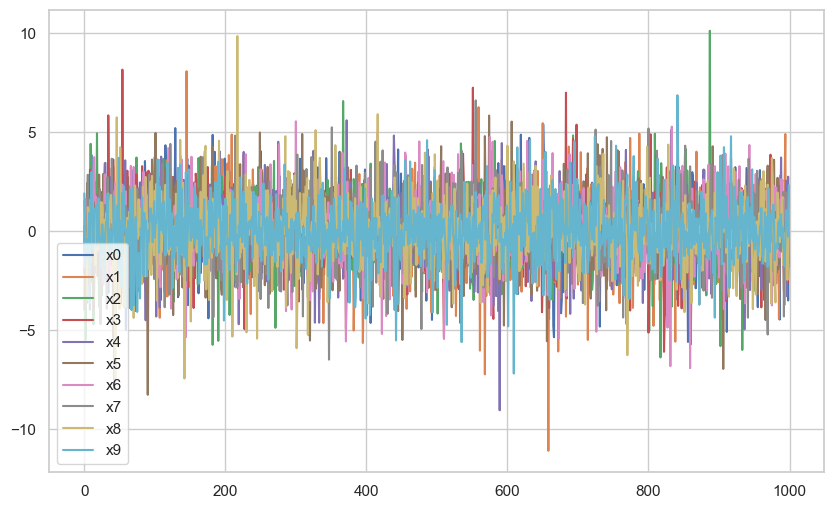

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
import cProfile



warnings.simplefilter('ignore')  # Ignore warnings
plt.rcParams["font.family"] = "MS Gothic"  # For using Japanese fonts in matplotlib

# VAR-LiNGAM artificial data generation function with PyTorch
def VARLiNGAM_generate(B0, B1, noise, device):
    n_samples, n_features = noise.shape
    
    # Initialize output tensor
    out = torch.zeros((n_samples, n_features), device=device, dtype=torch.float32)
    
    # Apply B0 to the initial noise terms
    out[0] = torch.linalg.solve(torch.eye(n_features, device=device, dtype=torch.float32) - B0, noise[0])
    
    # Generate data for subsequent time steps
    for t in range(1, n_samples):
        out[t] = torch.matmul(B1, out[t-1]) + noise[t]
        out[t] = torch.linalg.solve(torch.eye(n_features, device=device, dtype=torch.float32) - B0, out[t])
    
    return out

def generation_dataset(n_samples, n_features):
    # Parameters
    # n_samples = 10000
    # n_features = 200
    
    # Set device to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize B0 and B1 for large dimensions
    np.random.seed(0)
    B0 = torch.zeros((n_features, n_features), device=device, dtype=torch.float32)
    B1 = torch.zeros((n_features, n_features), device=device, dtype=torch.float32)
    
    # Randomly generate some non-zero entries for B0 and B1 to simulate real conditions
    num_connections = 2 # n_features // 50  # Adjust the sparsity
    for i in range(n_features):
        indices = torch.tensor(np.random.choice(n_features, num_connections, replace=False), dtype=torch.long, device=device)
        values_B0 = torch.tensor(np.random.uniform(-0.5, 0.5, num_connections), device=device, dtype=torch.float32)
        values_B1 = torch.tensor(np.random.uniform(-0.5, 0.5, num_connections), device=device, dtype=torch.float32)
        B0[i, indices] = values_B0
        B1[i, indices] = values_B1
    
    # Ensure B0 is a DAG by making it upper triangular
    B0 = torch.triu(B0, diagonal=1)
    
    # Generate noise
    noise = torch.from_numpy(np.random.laplace(size=(n_samples, n_features)).astype(np.float32)).to(device)
    
    # Measure elapsed time for data generation
    # import time
    # start_time = time.time()
    X_varlingam = VARLiNGAM_generate(B0, B1, noise, device)
    # end_time = time.time()
    # elapsed_time = end_time - start_time
    # print(f"Elapsed time for generation: {elapsed_time} seconds")
    
    # Move data back to CPU for further processing if necessary
    X_varlingam = X_varlingam.cpu().numpy()
    
    return B0, B1, X_varlingam


_,_, X_varlingam=generation_dataset(10000, 20)
# Create a DataFrame with the generated data
sampled_df = pd.DataFrame(data=X_varlingam[:1000], columns=[f'x{i}' for i in range(X_varlingam.shape[1])])
# Visualization
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
for i in range(min(X_varlingam.shape[1], 10)):  # Visualize only the first 10 variables to keep the plot readable
    plt.plot(sampled_df[f'x{i}'], label=f'x{i}')
plt.legend()
plt.show()


In [3]:
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import lingam
import time

# Define functions to process a single dataset
def process_dataset(n_samples, n_features, threshold=0):


    B0_groundtruth, B1_groundtruth, X = generation_dataset(n_samples, n_features)

    n_samples = X.shape[0]
    model = lingam.VARLiNGAM(lags=2)

    start_time = time.time()
    model.fit(X)
    end_time = time.time()
    execution_time = end_time - start_time

    adjacency_matrices = model.adjacency_matrices_
    
    result = np.zeros_like(adjacency_matrices[0])
    for idx, adj_matrix in enumerate(adjacency_matrices):
        result += np.abs(adj_matrix)
    
    result = (result > threshold).astype(int)

    B0_groundtruth = np.array(B0_groundtruth)
    B1_groundtruth = np.array(B1_groundtruth)

    causality_matrix = np.zeros_like(B0_groundtruth)
    causality_matrix += np.abs(B0_groundtruth)
    causality_matrix += np.abs(B1_groundtruth)
    

    precision, recall, f1_score, accuracy = precision_recall_f1(B0_groundtruth, adjacency_matrices[0])
    shd = structural_hamming_distance(B0_groundtruth, adjacency_matrices[0])#causality_matrix, result)
    error_rate = shd / (n_features ** 2)

    return {
        "features": n_features,
        "n_samples": n_samples,
        "SHD": shd,
        "error rate": error_rate,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1score": f1_score,
        "total excution time": execution_time
    }

# Define auxiliary functions for calculating indicators
def precision_recall_f1(matrix1, matrix2):
    assert matrix1.shape == matrix2.shape, "Matrices must have the same shape"

    bool_matrix1 = matrix1 != 0
    bool_matrix2 = matrix2 != 0

    TP = np.sum(np.logical_and(bool_matrix1, bool_matrix2))
    FP = np.sum(np.logical_and(np.logical_not(bool_matrix1), bool_matrix2))
    FN = np.sum(np.logical_and(bool_matrix1, np.logical_not(bool_matrix2)))
    TN = np.sum(np.logical_and(np.logical_not(bool_matrix1), np.logical_not(bool_matrix2)))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

    return precision, recall, f1_score, accuracy

def structural_hamming_distance(matrix1, matrix2):
    assert matrix1.shape == matrix2.shape, "Matrices must have the same shape"

    bool_matrix1 = matrix1 != 0
    bool_matrix2 = matrix2 != 0

    distance = np.sum(bool_matrix1 != bool_matrix2)

    return distance

# Define functions to handle all data sets
def process_all_datasets(output_file, threshold=0):
    n_samples=250
    n_features=50
    results=[]
    
    while n_samples<=16000:
        result = process_dataset(n_samples, n_features, threshold)
        results.append(result)
        n_samples=2*n_samples

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)


    return results_df

# set pathes
# path_input = './data/data_benchmark_1/fMRI_processed_by_Nauta/returns/'
# path_groundtruth = './data/data_benchmark_1/fMRI_processed_by_Nauta/ground_truth/'
output_file = 'artificial_results_samples_after.csv'

# Process all data sets and save the results
results_df = process_all_datasets(output_file, threshold=0)
print(results_df)


Estimate VAR coefficients time: 0.025510787963867188 seconds
precomputation Execution time: 0.20032048225402832 seconds
Measure method: pwling_v2
search causal order Execution time: 0.2052450180053711 seconds
estimate adjacency matrix Execution time: 0.20352935791015625 seconds
Estimate VAR coefficients time: 0.03453397750854492 seconds
precomputation Execution time: 0.21776485443115234 seconds
Measure method: pwling_v2
search causal order Execution time: 0.20332670211791992 seconds
estimate adjacency matrix Execution time: 0.24863648414611816 seconds
Estimate VAR coefficients time: 0.04100656509399414 seconds
precomputation Execution time: 0.2627086639404297 seconds
Measure method: pwling_v2
search causal order Execution time: 0.2160325050354004 seconds
estimate adjacency matrix Execution time: 0.29999542236328125 seconds
Estimate VAR coefficients time: 0.04526805877685547 seconds
precomputation Execution time: 0.3903534412384033 seconds
Measure method: pwling_v2
search causal order E

In [3]:
print(np.mean(results_df["f1score"]))
print(np.std(results_df["f1score"]))

0.6197515738247849
0.13946696550768203
